# Variational Dropout - (probably) the simplest Bayesian DL algorithm ever.

One of the simplest examples of Bayesian DL is a technique called [Variational Dropout](https://arxiv.org/pdf/1506.02142.pdf). This technique makes an extensive usage of a [Dropout technique](http://jmlr.org/papers/volume15/srivastava14a.old/srivastava14a.pdf) from which introduction we will start first:

## Vanilla Dropout

![Visualization of unit drop in dropout technique](example_images/variational_dropout/dropout.png)

The dropout technique applied to batch training consists of the following steps:
1. Multiply each activation unit $a$ by a sample from independent Bernouli distributions $B(p_a)$.
2. Perform _forward_ and _backward_ passes of neural network with masked activations.

The same technique can be also applied to weights.

### Let's have a look how it works

Let us introduce a dummy dataset:

In [1]:
import matplotlib.pyplot as plt

from examples import DummyDatasetForRegression


POINTS_PER_BLOB = 1000
SCALE = 0.6


dummy_dataset_for_regression = DummyDatasetForRegression(
    points_per_blob=POINTS_PER_BLOB,
    scale=SCALE,
)
dummy_dataset_for_regression.visualize_dataset()
plt.show()

<Figure size 700x600 with 2 Axes>

Now - let us introduce a simple model for regression:

In [2]:
from keras import models
from keras import layers

ACTIVATION = 'relu'
INITIALIZER = 'glorot_normal' 
EPOCHS = 100

def build_simple_model(layer_size=200, activation='relu', initializer=INITIALIZER):
    input_to_model = layers.Input(shape=(1,))
    aux_layer = input_to_model
    aux_layer = layers.Dense(
        layer_size,
        activation=activation,
        kernel_initializer=initializer,
    )(aux_layer)
    aux_layer = layers.Dense(
        layer_size,
        activation=activation,
        kernel_initializer=initializer,
    )(aux_layer)    
    output = layers.Dense(1, kernel_initializer=initializer)(aux_layer)
    
    model_ = models.Model(input_to_model, output)
    model_.compile(loss='mse', optimizer='adam')
    return model_

model = build_simple_model(activation=ACTIVATION)
model.summary()

Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 200)               400       
_________________________________________________________________
dense_2 (Dense)              (None, 200)               40200     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 201       
Total params: 40,801
Trainable params: 40,801
Non-trainable params: 0
_________________________________________________________________


Now - we can fit a model to check what has it learnt:

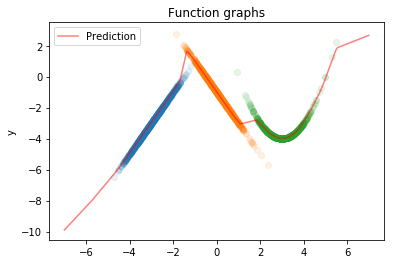

In [3]:
full_dataset = dummy_dataset_for_regression.full_dataset
simple_history = model.fit(full_dataset.x, full_dataset.y, epochs=EPOCHS, verbose=0)
dummy_dataset_for_regression.visualize_model(model=model)

### Variational Dropout

Variational Dropout technique in it's vanila version is simply to leave masking of neurons also during the inference time. 

Let's have a look how it might be implemented in `keras`:

In [4]:
import keras.backend as K


def build_dropout_model(
    layer_size=200,
    dropout_rate=0.5,
    activation='relu',
    initializer=INITIALIZER,
):
    input_to_model = layers.Input(shape=(1,))
    aux_layer = input_to_model
    aux_layer = layers.Dense(
        layer_size,
        activation=activation,
        kernel_initializer=initializer,
    )(aux_layer)
    aux_layer = layers.Lambda(lambda x: K.dropout(x, dropout_rate))(aux_layer)
    aux_layer = layers.Dense(
        layer_size,
        activation=activation,
        kernel_initializer=initializer,
    )(aux_layer)
    aux_layer = layers.Lambda(lambda x: K.dropout(x, dropout_rate))(aux_layer)
    output = layers.Dense(1)(aux_layer)
    
    model_ = models.Model(input_to_model, output)
    model_.compile(loss='mse', optimizer='adam')
    return model_

dropout_model = build_dropout_model(activation=ACTIVATION)
dropout_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 1)                 0         
_________________________________________________________________
dense_4 (Dense)              (None, 200)               400       
_________________________________________________________________
lambda_1 (Lambda)            (None, 200)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 200)               40200     
_________________________________________________________________
lambda_2 (Lambda)            (None, 200)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 201       
Total params: 40,801
Trainable params: 40,801
Non-trainable params: 0
_________________________________________________________________


Now - let's train the model:

In [5]:
simple_dropout_history = dropout_model.fit(
    x=full_dataset.x,
    y=full_dataset.y, 
    epochs=EPOCHS,
    verbose=0,
)

And visualize its results:

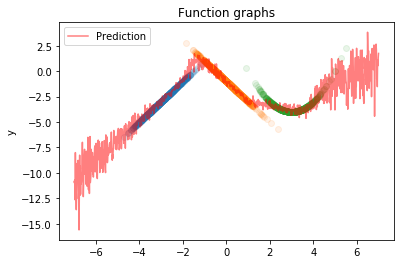

In [6]:
dummy_dataset_for_regression.visualize_model(model=dropout_model)

Beside of that - we can check how samples are distributed:

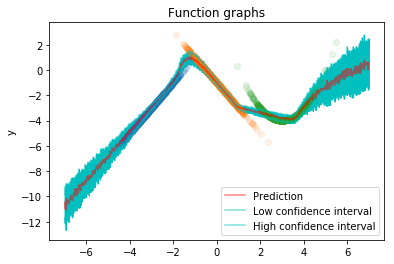

In [7]:
dummy_dataset_for_regression.visualize_variational_model(model=dropout_model, nb_of_samples=50)

Now - you can play around with `POINTS_PER_BLOB` size. Do the confidence interval change? Why?

![Visualization of unit drop in dropout technique](example_images/variational_dropout/dropout_lemma.png)
This piece comes from [Randomized Prior Functions
for Deep Reinforcement Learning, Osband et al.](https://arxiv.org/pdf/1806.03335.pdf)

This is pretty obvious why - unless Variational Dropout does not have learnable distributional parameters - it will suffer from this problem. One possible solution? 

### Concrete Dropout

There are many ways on how one can train a dropout rate. One possible way is to use the following alternated `sigmoid` activation:

$$S' = sigmoid\left(\frac{1}{t}\left(\log p - \log(1-p) + \log u - log(1 -u)\right)\right),$$

where $u \sim Unif(0, 1)$. This is the way how the function was presented in [original Concrete Dropout](https://arxiv.org/pdf/1705.07832.pdf) paper. But if we introduce another function:

$$sigmoid^{-1}(p) = \log p - \log 1 - p,$$

which is the actual inverse function of $sigmoid$ - the new activation might be presented in a slightly more understandable manner:

$$S'(p) = sigmoid\left(\frac{1}{t}\left(sigmoid^{-1}(p) + sigmoid^{-1}(u)\right)\right),$$

Let's have a look at `concrete_sigmoid` function - how it behaves and how it might simulate dropout sampling:

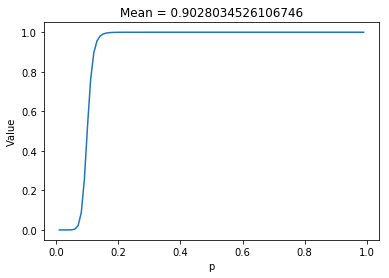

In [8]:
from utils import plot_concrete_sigmoid

TEMPERATURE = 0.1
P = 0.9
STEPS = 100

plot_concrete_sigmoid(p=P, t=TEMPERATURE, step=STEPS)

So - as one may see - this function might be treated as differentiable sampling.

There was no $prior$ component in Variational Dropout (why?). In case of Concrete Dropout the following regularization is used:

$$KL\left(q_M(W)|p(W)\right) = \frac{l(1 - p)}{2} \lVert M \rVert_2^2 - K\mathcal{H}(p),$$

where: 

- $M$ is layer weights matrices,
- $\mathcal{H}$ is entropy,
- $p$ is predicted dropout rate.

Now - let's use the authors implementation in order to have fun with the Concrete Dropout:

In [9]:
from concrete_dropout import ConcreteDropout

def build_concrete_dropout_model(
    layer_size=200,
    activation=ACTIVATION,
    initializer=INITIALIZER,
):
    input_to_model = layers.Input(shape=(1,))
    aux_layer = input_to_model
    aux_layer = ConcreteDropout(layers.Dense(
        layer_size,
        activation=activation,
        kernel_initializer=initializer,
    ))(aux_layer)
    aux_layer = ConcreteDropout(layers.Dense(
        layer_size,
        activation=activation,
        kernel_initializer=initializer,
    ))(aux_layer)
    output = layers.Dense(1, kernel_initializer=initializer)(aux_layer)
    
    model_ = models.Model(input_to_model, output)
    model_.compile(loss='mse', optimizer='adam')
    return model_

concrete_dropout_model = build_concrete_dropout_model()

Now - let's train it:

In [10]:
concrete_dropout_history = concrete_dropout_model.fit(
    x=full_dataset.x,
    y=full_dataset.y,
    epochs=EPOCHS,
    verbose=0,
)

And see how it works:

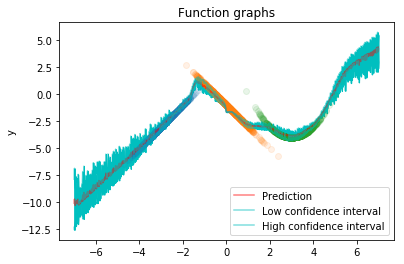

In [11]:
dummy_dataset_for_regression.visualize_variational_model(model=concrete_dropout_model, nb_of_samples=50)

Now - let's compare all of the methods:

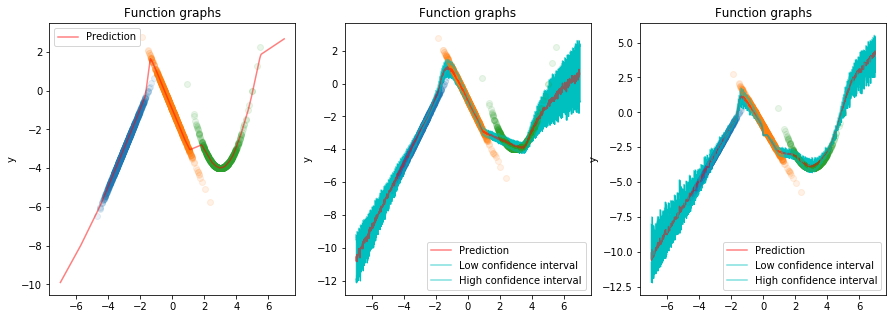

In [12]:
NUMBER_OF_SAMPLES = 100

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.title('Dropout model')
dummy_dataset_for_regression.visualize_model(model=model)
plt.subplot(1, 3, 2)
plt.title('Variational Dropout model')
dummy_dataset_for_regression.visualize_variational_model(
    model=dropout_model, 
    nb_of_samples=NUMBER_OF_SAMPLES,
)
plt.subplot(1, 3, 3)
plt.title('Concrete dropout model')
dummy_dataset_for_regression.visualize_variational_model(
    model=concrete_dropout_model, 
    nb_of_samples=NUMBER_OF_SAMPLES,
)

### Bayes-by-backprop

In many methods - the $q(w|\theta)$ is created using latent, normally distributed variables. [Bayes-by-backprop](https://arxiv.org/pdf/1505.05424.pdf) technique will serve us as a gentle introduction to this methods. In this technique, all weights are sampled independently and the distribution $q\left(w|\left(\mu, \rho\right)\right)$ is given by equation:
$$w \sim \mathcal{N}\left(\mu, \log\left(1 + \exp\rho\right)\right).$$

From now on, let us denote:

$$softplus(x) = \log\left(1 + \exp x\right)$$

The prior is given by $w \sim \mathcal{N}(0, \sigma_p)$. This results in the following function loss:

$$loss = KL\left(\mathcal{N}\left(\mu, softplus(\rho)\right)|\mathcal{N}\left(0, \sigma_p\right)\right) + MSE.$$

From this it is easy to compute that:

$$KL(\mathcal{N}\left(\mu, \log\left(1 + \exp\rho\right)|\mathcal{N}\left(0, \sigma_p\right)\right) = -\log softplus(\rho) + \frac{softplus(\rho)^2 + \mu^2}{2\sigma_p^2}.$$

Now - let us have fun with implementing Bayes by Backprop technique in `keras`.

In [13]:
from keras import regularizers
from keras.engine.topology import Layer
from keras import activations


class BayesByBackprop(Layer):
    
    def __init__(self, output_dim, activation=None, **kwargs):
        self._output_dim = output_dim
        self._activation = activation
        self._regularization_rate = 0.01
        self._mu = None
        self._log_sigma = None
        self._input_shape = None
        self._bias = None
        self._activation = activations.get(activation)
        super().__init__(**kwargs)
        
    def _softplus(self, x):
        return K.log(1 + K.exp(x))
    
    def _mu_regularizer(self, mu):
        return self._regularization_rate * 0.5 * K.sum(K.square(mu))
    
    def _log_sigma_regularizer(self, log_sigma):
        sigma = self._softplus(log_sigma)
        return -0.5 * self._regularization_rate * K.sum(2 * K.log(sigma) - K.square(sigma))
    
    def build(self, input_shape):
        self._input_shape = input_shape[1]
        self._mu = self.add_weight(
            name='mu', 
            shape=(input_shape[1], self._output_dim),
            initializer='glorot_normal',
            regularizer=self._mu_regularizer,
            trainable=True,
        )
        self._bias = self.add_weight(
            name='bias', 
            shape=(self._output_dim,),
            initializer='zeros',
            trainable=True,
        )
        self._log_sigma = self.add_weight(
            name='sigma', 
            shape=(input_shape[1], self._output_dim),
            initializer='glorot_normal',
            regularizer=self._log_sigma_regularizer,
            trainable=True,
        )
        super().build(input_shape)
        
    def compute_output_shape(self, input_shape):
        return (input_shape[0], self._output_dim)
        
    def call(self, x):
        perturbation = K.random_normal(shape=(self._input_shape, self._output_dim), mean=0, stddev=0.05)
        self.kernel = self._mu + perturbation * self._softplus(self._log_sigma)
        dot_product = K.bias_add(K.dot(x, self.kernel), self._bias, 'channels_last')
        return self._activation(dot_product)

Now - let us build a model:

In [14]:
def build_bbb_model(layer_size=200, activation=ACTIVATION):
    input_to_model = layers.Input(shape=(1,))
    aux_layer = input_to_model
    aux_layer = BayesByBackprop(layer_size, activation=ACTIVATION)(aux_layer)
    aux_layer = BayesByBackprop(layer_size, activation=ACTIVATION)(aux_layer)
    output = layers.Dense(1)(aux_layer)
    
    model_ = models.Model(input_to_model, output)
    model_.compile(loss='mse', optimizer='adam')
    return model_

bbb_model = build_bbb_model()
bbb_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 1)                 0         
_________________________________________________________________
bayes_by_backprop_1 (BayesBy (None, 200)               600       
_________________________________________________________________
bayes_by_backprop_2 (BayesBy (None, 200)               80200     
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 201       
Total params: 81,001
Trainable params: 81,001
Non-trainable params: 0
_________________________________________________________________


... and train it:

In [15]:
bbb_history = bbb_model.fit(
    x=full_dataset.x,
    y=full_dataset.y,
    epochs=EPOCHS,
    verbose=0,
)

Let us have a look how it works:

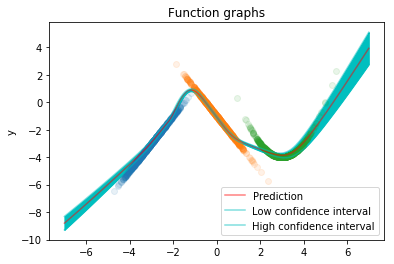

In [16]:
dummy_dataset_for_regression.visualize_variational_model(model=bbb_model, nb_of_samples=50)

Well, in many hyper-parameters setups - the graph above looks really poor. This was partially observed and tackled by authors of [original](https://arxiv.org/pdf/1505.05424.pdf) paper by introduction of slightly different scale-mixture prior. But there is yet another important issue connected to models which uses the mixture of independent Gaussian latent variables. It is best stated (once again) in [Randomized Prior Functions for Deep Reinforcement Learning](https://arxiv.org/abs/1806.03335):
!['Lemma 2'](example_images/variational_dropout/Lemma-2.png)
So - for the best fit - it is the best to set the latent variable variance to $0$. But then we do not propagate uncertainty. If we choose to set the latent variable variance to $\sigma > 0$ - we are increasing the approximation error. 

### Randomized Prior Functions

In this work, we have already cited the paper [Randomized Prior Functions for Deep Reinforcement Learning](https://arxiv.org/abs/1806.03335) on multiple occasions. Now - let us have a look at the method presented by the authors of the paper. They use the following lemma:
!['Lemma 4'](example_images/variational_dropout/Lemma-3.png)
The authors argue that although this method has been proven only for Linear Regression - it might be easily extended to other methods, e.g. neural networks. This is how the final algorith looks like:
!['Algo 4'](example_images/variational_dropout/algo-1.png)
Now - let us implement this method and check how it works:

In [17]:
import numpy as np
import sklearn.utils as skutils

class RandomizedPriorFunctions:
    
    def __init__(
        self,
        prior_functions, 
        model_factory,
        bootstrap_factor=0.1,
        random_noise_scale=0.1
    ):
        self._prior_functions = prior_functions
        self._model_factory = model_factory
        self._bootstrap_factor = bootstrap_factor
        self._random_noise_scale = random_noise_scale
        self._models = None
        
    def _bootstrap(self, x, y):
        nb_of_samples = int(len(x) * self._bootstrap_factor)
        return skutils.resample(x, y, n_samples=nb_of_samples)
        
    def _data_noise(self, x, y):
        new_x, new_y = self._bootstrap(x, y)
        new_y = new_y.reshape((-1, 1))
        new_y = new_y + np.random.normal(
                scale=self._random_noise_scale,
                size=new_y.shape,
            )
        return new_x, new_y
        
    def fit(self, x, y, **kwargs):
        self._models = []
        for prior_function in self._prior_functions:
            new_x, new_y = self._data_noise(x, y)
            prior_function_value = prior_function(new_x).reshape((-1, 1))
            new_y = new_y - prior_function_value
            current_model = self._model_factory()
            current_model.fit(new_x, new_y, **kwargs)
            self._models.append(current_model)
            
    def predict(self, x):
        return np.concatenate(
            [model.predict(x).reshape((1, -1)) + prior_function(x).reshape((1, -1))
             for model, prior_function in zip(self._models, self._prior_functions)])
    
    @staticmethod
    def _get_random_functions(nb_of_functions):
        functions = []
        for _ in range(nb_of_functions):
            def _current_function(x):
                params = np.random.normal(size=3, scale=0.1)
                result = x ** 2 * params[0] + x * params[1] + params[2]
                return result
            functions.append(_current_function)
        return functions
    
    @classmethod
    def example(cls, nb_of_functions, model_factory, bootstrap_factor):
        random_functions = cls._get_random_functions(nb_of_functions=nb_of_functions)
        return cls(
            prior_functions=random_functions,
            bootstrap_factor=bootstrap_factor,
            model_factory=model_factory,
        )

Now - let us build the model...

In [18]:
NB_OF_PRIOR_FUNCTIONS = 10
BOOTSTRAP_FACTOR = 0.9


randomized_prior_functions_model = RandomizedPriorFunctions.example(
    nb_of_functions=NB_OF_PRIOR_FUNCTIONS,
    model_factory=build_simple_model,
    bootstrap_factor=BOOTSTRAP_FACTOR,
)

... and fit it:

In [ ]:
randomized_prior_functions_model.fit(
    x=full_dataset.x,
    y=full_dataset.y,
    epochs=EPOCHS,
    verbose=0,
)

Finally - let us check how it works:

In [ ]:
dummy_dataset_for_regression.visualize_prior_ensemble_model(model=randomized_prior_functions_model)

For more materials you can look for [here](https://gitlab.com/MarcinMozejko/materials).